<a href="https://colab.research.google.com/github/vinismachadoo/otimizacao-petroleo-offshore/blob/main/producao_bacia_campos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas -q

     |████████████████████████████████| 972kB 5.8MB/s 
     |████████████████████████████████| 14.8MB 310kB/s 
     |████████████████████████████████| 6.5MB 47.5MB/s 


In [56]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
!wget 'http://hmlapp5.anp.gov.br/geoserver/oracleworskspace/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP'
!unzip 'ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP'

--2020-11-21 16:26:17--  http://hmlapp5.anp.gov.br/geoserver/oracleworskspace/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP
Resolving hmlapp5.anp.gov.br (hmlapp5.anp.gov.br)... 200.186.194.21
Connecting to hmlapp5.anp.gov.br (hmlapp5.anp.gov.br)|200.186.194.21|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP’

ows?service=WFS&ver     [             <=>    ] 505.56K   145KB/s    in 3.5s    

2020-11-21 16:26:22 (145 KB/s) - ‘ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP’ saved [517693]

Archive:  ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&o

In [4]:
!wget 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/RJ/rj_municipios.zip'
!unzip rj_municipios.zip

--2020-11-21 16:26:22--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/RJ/rj_municipios.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 170.84.40.11
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|170.84.40.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5164588 (4.9M) [application/zip]
Saving to: ‘rj_municipios.zip’

rj_municipios.zip   100%[===================>]   4.92M   628KB/s    in 8.0s    

2020-11-21 16:26:32 (628 KB/s) - ‘rj_municipios.zip’ saved [5164588/5164588]

Archive:  rj_municipios.zip
 extracting: RJ_Municipios_2019.cpg  
  inflating: RJ_Municipios_2019.dbf  
  inflating: RJ_Municipios_2019.prj  
  inflating: RJ_Municipios_2019.shp  
  inflating: RJ_Municipios_2019.shx  


In [61]:
campos_producao = gpd.read_file('CAMPOS_PRODUCAO_SIRGASPolygon.shp')
municipios_rj = gpd.read_file('RJ_Municipios_2019.shp')

In [62]:
bacia_campos = campos_producao[campos_producao.NOM_BACIA == 'Campos']

In [63]:
operadores = {
    'Shell Brasil Petróleo Ltda.': 'Shell Brasil',
    'Dommo Energia S.A': 'Dommo Energia',
    'Total E&P do Brasil Ltda.': 'Total E&P',
    'BW Energy Maromba do Brasil LTDA': 'BW Energy',
    'Petróleo Brasileiro S.A.': 'Petrobras',
    'Petro Rio O&G Exploração e Produção de Petróleo Ltda.': 'Petro Rio O&G',
    'Equinor Brasil Energia Ltda.': 'Equinor Brasil',
    'Perenco Petróleo e Gás do Brasil Ltda.': 'Perenco Brasil',
    'Petro Rio Jaguar Petróleo Ltda.': 'Petro Rio O&G'
}

bacia_campos.OPERADOR_C.replace(operadores, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [65]:
ueps_operacao = pd.read_csv('http://www.anp.gov.br/arquivos/dados-ep/ueps-operacao.csv', sep=';', header=1)
plataformas = ueps_operacao[ueps_operacao['Bacia '] == 'Campos ']

In [66]:
digitos_latitude = plataformas.Latitude.str.replace(",",".").str.split(":", expand=True)
plataformas['latitude_decimal'] = digitos_latitude[0].astype(int) - digitos_latitude[1].astype(float) / 60 - digitos_latitude[2].astype(float) / 3600
plataformas['latitude_radianos'] = np.deg2rad(plataformas['latitude_decimal'])

digitos_longitude = plataformas.Longitude.str.replace(",",".").str.split(":", expand=True)
plataformas['longitude_decimal'] = digitos_longitude[0].astype(int) - digitos_longitude[1].astype(float) / 60 - digitos_longitude[2].astype(float) / 3600
plataformas['longitude_radianos'] = np.deg2rad(plataformas['longitude_decimal'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [67]:
plataformas

,Sigla,Nome,Bacia,Tipo,Operador,Latitude,Longitude,Lâmina D'água (m),Capacidade de Processamento Petróleo (bbl/dia),Capacidade de Processamento Gás (Mil m³/dia),latitude_decimal,latitude_radianos,longitude_decimal,longitude_radianos
0,CAPX,FPSO CAPIXABA,Campos,FPSO,Petrobras,"-21:14:16,783","-39:57:46,397",1350,110000,3200,-21.237995,-0.370673,-39.962888,-0.697484
1,FCDA,FPSO CIDADE DE ANCHIETA,Campos,FPSO,Petrobras,"-21:20:16,965","-40:03:27,174",1221,100000,3500,-21.338046,-0.372419,-40.057548,-0.699136
3,FPCGZ,FPSO Cidade de Campos dos Goytacazes,Campos,FPSO,Petrobras,"-22:57:12,165","-40:43:31,966",765,150000,3500,-22.953379,-0.400612,-40.725546,-0.710795
10,FPNT,FPSO CIDADE DE NITEROI,Campos,FPSO,Petrobras,"-22:29:47,688","-39:56:14,785",1370,100000,3500,-22.496580,-0.392639,-39.937440,-0.697040
16,FPSO ESP SANTO,FPSO ESPIRITO SANTO,Campos,FPSO,Shell Brasil,"-21:12:30,854","-39:44:33,774",1775,100000,1400,-21.208571,-0.370159,-39.742715,-0.693641
17,FPSO FLUMINENSE,FPSO Fluminense,Campos,FPSO,Shell Brasil,"-22:38:57,206","-40:25:43,286",607,70000,2124,-22.649224,-0.395304,-40.428691,-0.705614
18,FPSO FRADE,FPSO FRADE,Campos,FPSO,Chevron Frade,"-21:53:03,196","-39:51:30,700",1065,100000,3000,-21.884221,-0.381952,-39.858528,-0.695663
20,OSX1,FPSO_OSX1,Campos,FPSO,Dommo Energia,"-23:32:07,003","-41:26:12,643",130,40000,1500,-23.535279,-0.410768,-41.436845,-0.723209
21,OSX3,FPSO_OSX3,Campos,FPSO,Dommo Energia,"-23:08:08,977","-41:04:24,717",105,100000,1500,-23.135827,-0.403796,-41.073533,-0.716868
22,PEREGRINO A,Peregrino A,Campos,FIXA,Equinor Brasil,"-23:20:03,631","-41:17:54,162",106,0,0,-23.334342,-0.407261,-41.298378,-0.720793


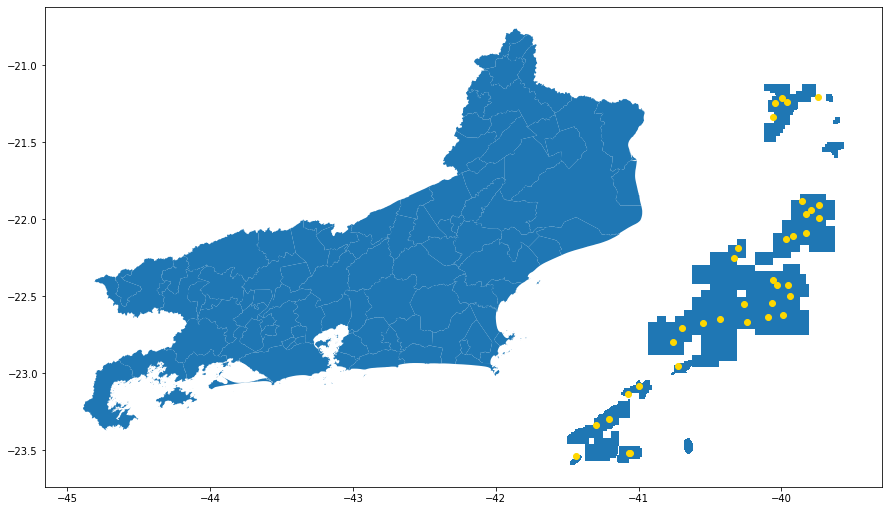

In [68]:
fig, ax = plt.subplots(figsize = (15,10))
bacia_campos.plot(ax=ax)
municipios_rj.plot(ax=ax)
ax.scatter(plataformas['longitude_decimal'], plataformas['latitude_decimal'], color='gold')

plt.show()